## Intercomparison of 3D Radiation Codes (I3RC): https://i3rc.gsfc.nasa.gov/
-----

##### Description
I3RC is an ongoing project initiated in the late 1990s. Its goals include: 
- Comparing methods available for 3D atmospheric radiative transfer calculations.
- Providing benchmark results for testing and debugging 3D radiative transfer codes.
- Publishing an open source toolkit (community 3D Monte Carlo code).
- Helping atmospheric science education by creating an archive of illustrative images and other resources on 3D radiative transfer.

Benchmark test-cases are devided into three phases. This notebook implements them for the mitsuba-renderer (https://www.mitsuba-renderer.org/), comparing it to gold-standard atmospheric science codes.


##### Phase I
Includes several baseline radiative computations for 3D radiative transfer through the following cloud fields:
1. 1D academic 'step' cloud field
2. 2D field derived from the ARM cloud radar
3. 3D field derived from radiances measured by the Landsat Thematic Mapper instrument

These computations involved cloud and surface only (i.e., no gases or aerosol) and were monochromatic, with scattering and absorption only (i.e., no emission), and were completed independently at each participants' home institutions.

---
#### Outputs

Mean and higher order moments of: 
   1. albedo (R)
   2. transmittance (T)
   3. absorptance (wherever applicable) (A)
   4. net horizontal flux (H) defined as $1-R-T-A$
   5. nadir reflectivity (Iu) defined as $\pi\nu / (F \mu_0)$ where: 
       - $\nu$ - upward exiting radiance at 0 degrees
       - $\mu_0$ - cosine of the solar zenith angle
       - $F=1$ is the incident solar flux
   6. oblique reflectivities (Io) defined as $\pi N_o / (F\mu_0)$ where:
       - $N_o$ - upward exiting radiance at 60 degrees zenith and 0 and 180 degrees azimuth angles (i.e. two oblique reflectivities are requested)
   7. zenith transmissivity (Id) defined as $\pi N_d/(F\mu_0)$ where:
       - $N_d$ - downward exiting radiance at 180 degrees (requested only when SZA=60)


Higher order moments are calculated as 
$$ \frac{1}{N}\sum_{i=1}^N (x_i-\bar{x})^k, \quad k=2,6 \quad  N=32$$

---
#### Consensus Results :

http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case1.tar

File format: I3RC_cons_res_case1_exp#_RQ.txt 

http://i3rc.gsfc.nasa.gov/input/step_cloud/README.txt

#### Compare mitsuba to I3RC consensus results:
---

     Exp.#    
        1.    SZA = 0,  w0 = 1
        2.    SZA = 60, w0 = 1
        3.    SZA = 0,  w0 = 0.99
        4.    SZA = 60, w0 = 0.99
    
    "RQ" is the radiative quantity. RQ takes the following values:
        - RQ=R     (reflectance)
        - RQ=T     (transmittance)
        - RQ=A     (absorptance)
        - RQ=H     (net horizontal flux)
        - RQ=Iu    (nadir reflectivity)
        - RQ=I601  (reflectivity at 60 view, 0 azimuth)
        - RQ=I602  (reflectivity at 60 view, 180 azimuth)
        - RQ=Id    (zenith transmissivity) 

### 1D academic step cloud field
---
#### Scenario 
- X-direction: $32$ columns (pixels): 16 have an optical depth of $\tau=2$. The remaining have $\tau=18$. Total size is 0.5km, thus $dx=0.5/32~ {\rm km}$.
- Y-direction: infinite.
- Z-direction: Geometrical thickness is set to 0.25 km everywhere (flat cloud).

  This is the Readme file for I3RC Case 1 (Step cloud) consensus results.                                              
  This file can be obtained at http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case1.tar    
---
#### Experiments
ASSUMPTIONS:
1. No atmospheric effects
2. Periodic boundary conditions (cloud field is repeated an infinite
   number of times along the x direction)
3. Henyey-Greenstein phase function (PF) with g=0.85
4. Black (zero reflectance) surface
5. Single scattering albedos w0=1 and w0=0.99 (with the same PF
   and extinction field).

SOLAR GEOMETRY: 
1. Sun at (SZA of) zero degrees
2. Sun at 60 degrees and 0 azimuth (Sun shining from low x coordinates)

In [1]:
import i3rc

# Mitsuba imports
from mitsuba.core import *
from mitsuba.render import Scene, RenderQueue, RenderJob

# Other imports and function defenitions 
import numpy as np
import matplotlib.pyplot as plt
import os, sys 

# Multiprocessing imports and initialization
import multiprocessing
scheduler = Scheduler.getInstance()

# Start up the scheduling system with one worker per local core
for i in range(0, multiprocessing.cpu_count()): 
    scheduler.registerWorker(LocalWorker(i, 'wrk%i' % i))
    #scheduler.registerWorker(LocalWorker(0, 'wrk0'))

scheduler.start()

In [2]:
case = 'case1'
consResult = i3rc.consresults[case]

# Create a queue for tracking render jobs
queue = RenderQueue()
pmgr = PluginManager.getInstance()
mtsResult = dict()
k=0
for experiment in i3rc.scenes.iterkeys():
    if k==0:
        k=1;
        continue;
    # If experiment is not in the consesnus result dont render with mitsuba
    if experiment not in consResult:
        continue
        
    scene = i3rc.scenes[experiment]
    size = scene.getSensor().getFilm().getSize()
    bitmap = Bitmap(Bitmap.ELuminance, Bitmap.EFloat32, size)

    job = RenderJob('myRenderJob', scene, queue)
    job.start()
    queue.waitLeft(0)

    # Develop the camera's film 
    scene.getFilm().develop(Point2i(0, 0), size, Point2i(0, 0), bitmap)
    mtsResult[experiment] = np.array(bitmap.buffer())
    

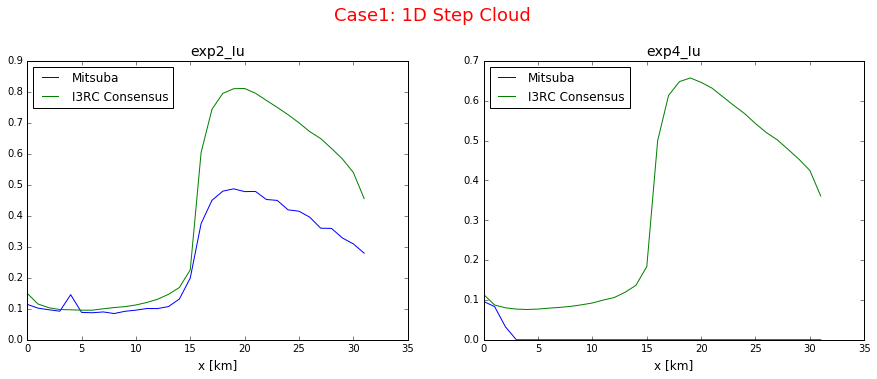

In [4]:
# Plot results for case1 experiments
%matplotlib inline 

f, axarr = plt.subplots(1, len(mtsResult), figsize=(15,5))
for ax, experiment in zip(axarr, mtsResult):
    ax.plot(np.pi * mtsResult[experiment].T, label='Mitsuba')
    ax.plot(consResult[experiment], label='I3RC Consensus')
    ax.legend(fontsize=12, loc='best')
    ax.set_title('{}'.format(experiment), fontsize=14); 
    ax.set_xlabel('x [km]', fontsize=12);

plt.suptitle('Case1: 1D Step Cloud', fontsize=18, y=1.05, color='r')
plt.show()

### 2D field derived from the ARM cloud radar

The 2D cloud field for this experiment is based on extinction retrievals from the MMCR (Millimiter Cloud Radar) and the MWR (microwave radiometer)at the ARM CART site in Lamont, OK on Feb. 8, 98. 

---
#### Scenario 
- X-direction: 640 columns (pixels) with 640m horizontal width
- Y-direction: Infinite.
- Z-direction: 54 vertical layers which are 45 meters thick 

  This is the Readme file for I3RC Case 1 (Step cloud) consensus results.                                              
  This file can be obtained at http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case1.tar    
---

#### Experiments
ASSUMPTIONS:
1. No atmospheric effects
2. Periodic boundary conditions (cloud field is repeated an infinite
   number of times along the x direction)
3. Henyey-Greenstein phase function (PF) with g=0.85 and C.1
   (Dermeindjian 1969)
4. Black (zero reflectance) surface
5. Single scattering albedos w0=1 and w0=0.99 (with the same PF
   and extinction field).

SOLAR GEOMETRY: 
1. Sun at (SZA of) zero degrees
2. Sun at 60 degrees and 0 azimuth (Sun shining from low x coordinates)

In [ ]:
#case = 'case2'
#consResult = i3rc.consresults[case]

In [ ]:
ec2 = boto3.resource('ec2')
instances = ec2.create_instances(
    ImageId='ami-2ffe2440', 
    MinCount=1, 
    MaxCount=1,
    KeyName='mitsuba',
    InstanceType='t2.micro',
    SecurityGroups=['All']
)

In [ ]:
from collections import defaultdict

runningInstances = ec2.instances.filter(Filters=[{'Name': 'instance-state-name', 'Values': ['running']}])

ec2info = defaultdict()
for instance in runningInstances:       
    ec2info[instance.id] = {
        'Type': instance.instance_type,
        'State': instance.state['Name'],
        'Private IP': instance.private_ip_address,
        'Public IP': instance.public_ip_address,
        'Launch Time': instance.launch_time,
        'Security Groups' : instance.security_groups[0]['GroupName']
        }

attributes = ['Type', 'State', 'Private IP', 'Public IP', 'Launch Time', 'Security Groups']
for instance_id, instance in ec2info.items():
    for key in attributes:
        print("{0}: {1}".format(key, instance[key]))
    print("------------------------------")

In [ ]:
import i3rc, paramiko

# Mitsuba imports
from mitsuba.core import *
from mitsuba.render import Scene, RenderQueue, RenderJob

# Other imports and function defenitions 
import numpy as np
import matplotlib.pyplot as plt
import os, sys 

In [ ]:
# Connect to a socket on a named host or IP address
# 7554 is the default port of 'mtssrv'
keyPath = os.path.join(os.environ['HOME'], 'Dropbox/Research/AWS/mitsuba.pem')

key = paramiko.RSAKey.from_private_key_file(keyPath)
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())

ssh.connect(hostname='52.57.33.140', 
            username='ubuntu', 
            pkey=key)

stdin, stdout, stderr = ssh.exec_command("cd code/mitsuba/dist")
stdin, stdout, stderr = ssh.exec_command("mtsserv")

# Wait for the command to terminate
while not stdout.channel.exit_status_ready():
    # Only print data if there is data to read in the channel
    if stdout.channel.recv_ready():
        rl, wl, xl = select.select([stdout.channel], [], [], 0.0)
        if len(rl) > 0:
            # Print data from stdout
            print stdout.channel.recv(1024),

#
# Disconnect from the host
#
print "Command done, closing SSH connection"
ssh.close()

In [ ]:
stream = SocketStream('52.57.33.140', 7554)

#Create a remote worker instance that communicates over the stream
remoteWorker = RemoteWorker('netWorker', stream)
scheduler = Scheduler.getInstance()

# Register the remote worker (and any other potential workers)
scheduler.registerWorker(remoteWorker)
scheduler.start()

In [ ]:
# Multiprocessing imports and initialization
import multiprocessing
scheduler = Scheduler.getInstance()

# Start up the scheduling system with one worker per local core
for i in range(0, multiprocessing.cpu_count()): 
    scheduler.registerWorker(LocalWorker(i, 'wrk%i' % i))

scheduler.start()

In [ ]:
running = ec2.instances.filter(
    Filters=[{'Name': 'instance-state-name', 'Values': ['running']}])
running.terminate()